In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Preprocessing

## 1-1. hyper-parameter 정의

In [ ]:
path="./gdrive/My Drive/Colab Notebooks/mitbih_database"
#path="./(록스)mitbih_database/"
window_size=160
maximum_counting=10000

classes=['N','L','R','A','V','/']
n_classes=len(classes)
count_classes=[0]*n_classes
X,Y=[],[]

In [ ]:
filenames= os.listdir(path)
records,annotations=[],[]
for f in filenames:
    if f.split('.')[1]=='txt':
        annotations.append(path+"/"+f)
    if f.split('.')[1]=="csv":
        records.append(path+"/"+f)

## 1-2. beat 정의 및 X, Y 초기화

In [ ]:
for i in range(len(records)):
    record=pd.read_csv(records[i],index_col=0)
    signals=[]
    try:
        signals.extend(record.loc[:,"'MLII'"].to_list())
    except:
        #메인 리드가 MLII가 아닌 것은 제외한다.
        print(records[i].split('/')[-1]+" 메인 리드 :",end=" ")
        print(record.columns[0])
        continue

    beat=[]

    annotation=open(annotations[i],'r')
    lines=annotation.readlines()
    for line in lines[1:]: #lines의 0은 Header
        tmp=line.split(' ')
        tmp=filter(None, tmp)
        next(tmp)
        pos=int(next(tmp))
        arrhythmia_type=next(tmp)
        if(arrhythmia_type in classes):
            arrhythmia_index=classes.index(arrhythmia_type)
            if count_classes[arrhythmia_index]> maximum_counting:
                continue
            else:
                count_classes[arrhythmia_index]+=1
                if(window_size<pos and pos<(len(signals)-window_size)): 
                    beat=signals[pos-window_size+1:pos+window_size] #beat size
                    X.append(beat)
                    Y.append(arrhythmia_index)

102.csv 메인 리드 : 'V5'
104.csv 메인 리드 : 'V5'


## 1-3. Data shape

(41738, 319) (41738,)
N
V
A
R
/
L


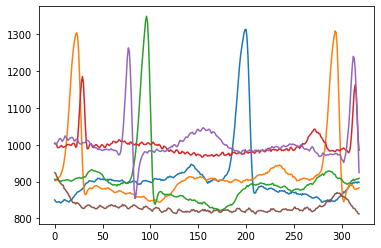

In [ ]:
print(np.shape(X),np.shape(Y))

tmp=[]
for i in range(len(X)):
    if Y[i] not in tmp:
        tmp.append(Y[i])
        plt.plot(X[i])
        print(classes[Y[i]])

In [ ]:
# X 배열 끝에 Y값 삽입
for i in range(len(X)):
    X[i].append(Y[i])

In [ ]:
X_train_df = pd.DataFrame(X)
#각각의 beat type의 count
per_class=X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class) #V5 포함했을 때와 비교했을 때 '5'의 카운트가 크게 차이남

0    9993
1    8071
2    7255
4    7065
5    7023
3    2331
Name: 319, dtype: int64


## 1-4. Resampling

(확인 필요)

### 5000 이상 : 중복 X   // 5000 이하 : 중복 O

In [ ]:
from sklearn.utils import resample
resampled_X_train_df=pd.DataFrame()
for name, group in X_train_df.groupby(X_train_df[X_train_df.shape[1]-1]):
    if len(group)>5000:
        tmp=resample(group,replace=False,n_samples=5000, random_state=880818)
    else:
        tmp=resample(group,replace=True, n_samples=5000, random_state=880818)
    print(len(tmp))
    resampled_X_train_df=pd.concat([resampled_X_train_df,tmp])
print(len(resampled_X_train_df))
resampled_X_train_df

5000
5000
5000
5000
5000
5000
30000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319
5176,986,987,988,991,989,987,984,982,981,984,985,986,988,988,989,992,992,993,995,990,987,986,988,993,995,996,995,997,996,998,996,994,987,983,986,988,989,989,989,990,...,987,985,982,983,983,984,983,981,982,984,984,987,989,987,984,982,981,982,981,982,983,984,989,990,991,990,985,986,984,982,982,984,984,985,987,990,988,988,987,0
3685,967,968,966,965,965,963,967,967,969,965,962,963,967,969,966,966,966,969,973,977,980,980,979,980,979,982,982,980,980,980,982,984,980,979,977,978,978,976,975,973,...,991,992,991,991,995,996,996,995,995,995,994,994,997,999,998,999,997,1000,1000,1002,1001,998,999,997,1000,999,999,998,999,1001,1001,1004,1002,1003,1000,1000,1001,1005,1005,0
13447,1032,1026,1025,1025,1023,1027,1028,1025,1024,1021,1019,1020,1021,1018,1018,1011,1011,1011,1010,1006,1000,997,998,996,996,998,994,993,992,992,999,995,994,990,990,990,996,991,991,990,...,991,993,996,996,995,992,992,994,999,999,997,995,994,997,996,992,989,989,988,990,996,992,992,989,989,991,996,998,997,996,995,995,998,997,994,991,992,994,999,0
13321,948,951,952,948,949,947,951,953,954,951,950,947,946,952,953,952,949,949,952,958,954,953,953,954,952,958,959,959,957,955,954,956,957,959,957,955,957,960,961,959,...,984,985,985,985,982,978,977,975,979,982,982,979,979,976,975,978,975,971,969,972,970,973,973,971,968,969,971,974,973,970,968,970,974,977,975,973,968,970,973,0
4477,957,954,955,952,952,952,950,951,952,952,951,949,947,951,960,974,993,1021,1058,1104,1160,1221,1274,1308,1318,1297,1250,1188,1118,1051,998,964,946,940,940,948,955,955,954,949,...,968,962,961,956,952,952,953,953,955,954,955,953,953,950,948,951,951,950,951,952,955,957,958,958,955,956,952,954,955,956,956,959,960,960,963,962,961,958,959,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20286,1011,1010,1013,1014,1015,1014,1014,1011,1010,1006,1004,1003,1001,1000,1001,1001,1001,1001,1000,997,996,992,989,989,989,988,987,989,990,991,989,989,988,986,987,984,987,988,992,994,...,1010,1015,1013,1009,1011,1010,1008,1009,1009,1011,1013,1013,1014,1015,1013,1012,1011,1009,1009,1006,1009,1013,1016,1018,1019,1022,1022,1018,1014,1010,1008,1007,1008,1003,1003,1007,1009,1010,1013,5
20806,878,880,880,881,882,881,881,879,877,878,878,879,878,882,885,884,883,881,880,881,880,879,878,878,880,883,883,884,886,883,884,880,880,881,881,881,881,885,884,885,...,808,807,805,803,798,797,796,794,793,792,794,793,793,792,791,789,787,786,789,788,790,791,793,794,795,794,796,797,798,798,799,800,801,807,810,813,814,816,818,5
27478,954,952,947,947,946,947,947,944,943,942,945,943,936,930,927,930,929,926,926,924,923,922,923,926,925,922,919,921,922,925,927,926,923,924,925,925,924,916,908,904,...,925,927,925,924,920,918,919,920,923,925,920,925,927,927,923,917,914,919,921,927,929,928,922,922,922,922,924,924,922,920,920,925,926,925,927,926,926,928,927,5
27670,957,951,951,954,954,953,947,950,947,950,953,950,949,945,946,947,949,949,948,947,945,946,949,949,946,945,942,944,947,949,945,947,945,946,947,946,947,945,945,946,...,965,964,964,964,963,966,968,969,971,971,969,973,975,975,975,975,974,975,979,982,981,983,989,996,999,999,994,988,985,988,988,985,983,982,981,983,983,981,979,5


# 2. Modeling

## 2-1. Set 분할

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [ ]:
train, test=train_test_split(resampled_X_train_df,test_size=0.30)
print("X_train : ",len(train))
print("X_test : ",len(test))

X_train :  21000
X_test :  9000


In [ ]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
print("Y shape :",np.shape(y_train),np.shape(y_test))

x_train=train.iloc[:,:train.shape[1]-1].values
x_test=test.iloc[:,:test.shape[1]-1].values
x_train=x_train.reshape(len(x_train),x_train.shape[1],1)
x_test=x_test.reshape(len(x_test),x_test.shape[1],1)
print("X shape :",np.shape(x_train),np.shape(x_test))

Y shape : (21000, 6) (9000, 6)
X shape : (21000, 319, 1) (9000, 319, 1)


## 2-2. modeling 첫 시도

In [ ]:
from keras.layers import Input, Convolution1D, MaxPool1D, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix

In [ ]:
def network(x_train,y_train,x_test,y_test):
    im_shape=(x_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape),name='inputs_cnn')
    #conv. layer 1
    conv1_1=Convolution1D(64,(6),activation="elu",input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    #pooling layer 1
    pool1=MaxPool1D(pool_size=(3),strides=(2),padding="same")(conv1_1)
    #conv. layer 2
    conv2_1=Convolution1D(128,(3),activation="elu",input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    #conv. layer 3
    conv3_1=Convolution1D(128,(3),activation="elu",input_shape=im_shape)(conv2_1)
    conv3_1=BatchNormalization()(conv3_1)
    #pooling layer 2
    pool2=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv3_1)
    #conv. layer 4
    conv4_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(pool2)
    conv4_1=BatchNormalization()(conv4_1)
    #conv. layer 5
    conv5_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv4_1)
    conv5_1=BatchNormalization()(conv5_1)
    #pooling layer 3
    pool3=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv5_1)
    #flattened layer 1
    flatten=Flatten()(pool3)
    #dense layers
    dense_end1=Dense(1024,activation='elu')(flatten)
    
    #output layers
    main_output=Dense(6,activation='softmax',name='main_output')(dense_end1)
    
    model=Model(inputs=inputs_cnn,outputs=main_output)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    callbacks=[EarlyStopping(monitor='val_loss',patience=8),
              ModelCheckpoint(filepath='best_model.h5',monitor='val_loss',save_best_only=True)]
    
    history=model.fit(x_train, y_train, epochs=2, callbacks=callbacks, batch_size=32,validation_data=(x_test,y_test))
    model.load_weights('best_model.h5')
    return (model, history)

In [ ]:
model, history=network(x_train,y_train,x_test,y_test)

Epoch 1/2
657/657 [==============================] - 228s 347ms/step - loss: 1.7981 - accuracy: 0.5159 - val_loss: 9.1290 - val_accuracy: 0.2047
Epoch 2/2
657/657 [==============================] - 221s 337ms/step - loss: 0.8294 - accuracy: 0.7220 - val_loss: 7.8055 - val_accuracy: 0.2757


In [ ]:
scores=model.evaluate((x_test),y_test,verbose=0)
print("Accuracy:",scores[1]*100)

Accuracy: 27.566665410995483


###  Confusion Matrix

In [ ]:
y_pred=model.predict(x_test)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cnf_matrix)

[[951   0 232   3 219  62]
 [550  46 203  27 557 102]
 [616   0 710  10 136  22]
 [904   0 443   7 160  17]
 [685   1 321  21 464  26]
 [609   1 368   4 220 303]]


In [ ]:
import itertools

def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

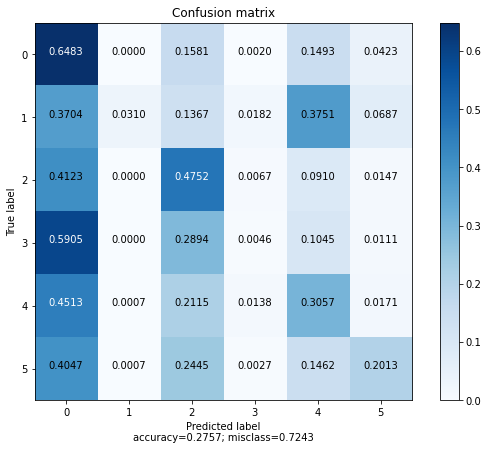

In [ ]:
plot_confusion_matrix(cnf_matrix, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix')

# 3. Modeling 두번째 시도

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
path="./gdrive/My Drive/Colab Notebooks/mitbih_database"
#path="./(록스)mitbih_database/"
classes=['N','L','R','A','V','/']
n_classes=len(classes)
count_classes=[0]*n_classes
X,Y=[],[]

In [ ]:
filenames= os.listdir(path)
records,annotations=[],[]
for f in filenames:
    if f.split('.')[1]=='txt':
        annotations.append(path+"/"+f)
    if f.split('.')[1]=='csv':
        records.append(path+"/"+f)

## 3-1. beat 정의 및 X, Y 초기화

#### set(사람)별로 편차가 큼
200번대 환자들은 유독 차이 큼

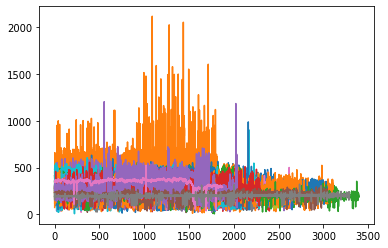

In [ ]:
import matplotlib.pyplot as plt

avg_list=[]
names=[]
for i in range(len(annotations)):
    names.append(annotations[i].split('/')[-1].split('.')[0].split('a')[0])
    annotation=open(annotations[i],'r')
    lines=annotation.readlines()
    a_list=[]
    for i in range(3,len(lines)):
        now=list(filter(None,lines[i].split(" ")))[1]
        before=list(filter(None,lines[i-1].split(" ")))[1]
        a_list.append(int(now)-int(before))

    plt.plot(range(0,len(a_list)),a_list)

    a_array=np.array(a_list)
    avg=np.mean(a_array)
    avg_list.append(avg)

■■■ 인원별 평균 비트의 길이 : 287.32487342487303 ■■■


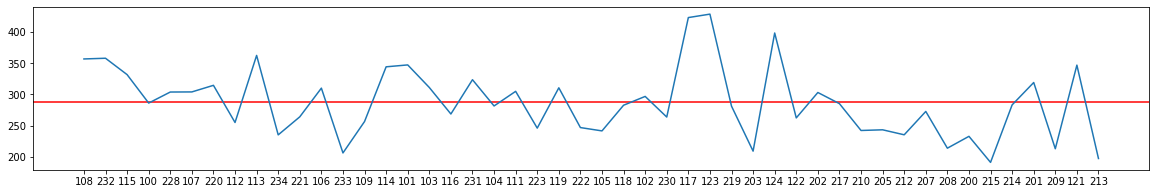

In [ ]:
print("■■■ 인원별 평균 비트의 길이 :",sum(avg_list)/len(avg_list),"■■■")
plt.figure(figsize=(20, 3))
plt.axhline(y=sum(avg_list)/len(avg_list), xmin=0, xmax=1,color='red')
plt.plot(names,avg_list)

In [ ]:
from IPython.display import display
from collections import defaultdict

person_aux_detection=defaultdict(int)
class_aux_dectection=defaultdict(int)

classes=['N','L','R','A','V','/']
n_classes=len(classes)
count_classes=[0]*n_classes
#maximum_counting=10000
X,Y=[],[]

for i in range(len(records)):
    record=pd.read_csv(records[i],index_col=0)
    signals=[]
    try:
        signals.extend(record.loc[:,"'MLII'"].to_list())
    except:
        #메인 리드가 MLII가 아닌 것은 제외한다.
        print(records[i].split('/')[-1]+" 메인 리드 :",end=" ")
        print(record.columns[0])
        continue

    beat=[]
    a=[]
    annotation=open(annotations[i],'r')
    lines=annotation.readlines()
    for j in range(3,len(lines)): # 1번 ~ 2번: 시작 지점이라 이상함
        now_tmp=list(filter(None,lines[j].split(" ")))
        # AUX 부분에 이상한 것 있으면 확인
        if now_tmp[-1] != '0\n':
            #print(records[i],":",now_tmp[-1].split("\t")[1])
            person_aux_detection[records[i].split('/')[-1].split('.')[0]]+=1
            class_aux_dectection[now_tmp[-1].split("\t")[1]]+=1
        before_tmp=list(filter(None,lines[j-1].split(" ")))
        now_num_sample=int(now_tmp[1])
        before_num_sample=int(before_tmp[1])
        beat_type=now_tmp[2]
        if (beat_type in classes):
            beat_idx=classes.index(beat_type)
            '''
            if count_classes[beat_idx] > maximum_counting: #################확인 필요#####################
                continue
            
            else:
                count_classes[beat_idx]+=1
                beat=signals[before_num_sample:now_num_sample]
                X.append(beat)
                if len(signals[before_num_sample:now_num_sample])>1000:
                    print("심박 1000 이상 찍힘 : ",annotations[i])
                Y.append(beat_idx)
            '''
            count_classes[beat_idx]+=1
            beat=signals[before_num_sample:now_num_sample]
            X.append(beat)
            Y.append(beat_idx)

102.csv 메인 리드 : 'V5'
104.csv 메인 리드 : 'V5'


In [ ]:
print(len(X))
print(len(Y))

102624
102624


### 각 비트별로 길이 차이가 심하게 나서 이를 확인하기 위해 AUX를 확인해봤다.
#### AUX 값 기반으로 새롭게 데이터를 생성한다.

In [ ]:
df_class_aux_dectection = pd.DataFrame([(k.split('\n')[0],v) for k,v in class_aux_dectection.items()],columns=['class','aux_num'])
df_person_aux_detection = pd.DataFrame([(k, v) for k, v in person_aux_detection.items()], columns=['id', 'aux_num'])
display(df_class_aux_dectection)
display(df_person_aux_detection)

,class,aux_num
0,(B,217
1,(N,455
2,TS,6
3,(SVTA,22
4,(T,82
5,(AFIB,69
6,(VT,61
7,MISSB,427
8,(BII,5
9,(P,56


,id,aux_num
0,208,43
1,221,16
2,230,2
3,232,22
4,233,40
5,122,70
6,109,2
7,119,437
8,124,44
9,103,27


#### AUX값 찍힌 곳이 전체 중에 1.58% 정도이므로 제거하도록 한다.
(이 중에는 아예 고장난 것도 포함되어 있다.)

In [ ]:
print("전체 X 값 :",len(X))
print("Aux 값 찍힌곳 :",sum(list(df_class_aux_dectection.iloc[:,1])))
print("비율 :",round((sum(list(df_class_aux_dectection.iloc[:,1]))/len(X))*100,2))

전체 X 값 : 102624
Aux 값 찍힌곳 : 1521
비율 : 1.48


#### 232번 환자는 따로 확인할 필요가 있다. 유독 비트당 길이가 매우 크다.
(일단 제외한다.)

In [ ]:
classes=['N','L','R','A','V','/']
n_classes=len(classes)
count_classes=[0]*n_classes

X,Y=[],[]
maximum_counting=10000

for i in range(len(records)):
    record=pd.read_csv(records[i],index_col=0)
    signals=[]
    try:
        signals.extend(record.loc[:,"'MLII'"].to_list())
    except:
        #메인 리드가 MLII가 아닌 것은 제외한다.
        print(records[i].split('/')[-1]+" 메인 리드 :",end=" ")
        print(record.columns[0])
        continue

    beat=[]
    a=[]
    annotation=open(annotations[i],'r')
    lines=annotation.readlines()
    for j in range(3,len(lines)): # 1번 ~ 2번: 시작 지점이라 이상함
        now_tmp=list(filter(None,lines[j].split(" ")))
        # AUX 부분에 이상한 것 있으면 제외
        if now_tmp[-1] != '0\n':
            continue
        before_tmp=list(filter(None,lines[j-1].split(" ")))
        now_num_sample=int(now_tmp[1])
        before_num_sample=int(before_tmp[1])
        beat_type=now_tmp[2]
        if (beat_type in classes):
            beat_idx=classes.index(beat_type)
            if count_classes[beat_idx] > maximum_counting: #################확인 필요#####################
                continue
            
            else:
                count_classes[beat_idx]+=1
                beat=signals[before_num_sample:now_num_sample]
                X.append(beat)
                Y.append(beat_idx)
                if len(signals[before_num_sample:now_num_sample])>1000:
                    print("심박 1000 이상 찍힘 : ",records[i].split('/')[-1].split('.')[0],"-",len(signals[before_num_sample:now_num_sample]))

심박 1000 이상 찍힘 :  222 - 1010
심박 1000 이상 찍힘 :  222 - 1001
심박 1000 이상 찍힘 :  222 - 1025
심박 1000 이상 찍힘 :  222 - 1110
심박 1000 이상 찍힘 :  222 - 1112
심박 1000 이상 찍힘 :  222 - 1137
심박 1000 이상 찍힘 :  222 - 1513
심박 1000 이상 찍힘 :  222 - 1114
심박 1000 이상 찍힘 :  222 - 1476
심박 1000 이상 찍힘 :  222 - 1182
심박 1000 이상 찍힘 :  222 - 1041
심박 1000 이상 찍힘 :  222 - 2114
심박 1000 이상 찍힘 :  222 - 1588
심박 1000 이상 찍힘 :  222 - 1003
심박 1000 이상 찍힘 :  222 - 1253
심박 1000 이상 찍힘 :  222 - 1446
심박 1000 이상 찍힘 :  222 - 1073
심박 1000 이상 찍힘 :  222 - 1161
심박 1000 이상 찍힘 :  222 - 1130
심박 1000 이상 찍힘 :  222 - 1080
심박 1000 이상 찍힘 :  222 - 1492
심박 1000 이상 찍힘 :  222 - 1120
심박 1000 이상 찍힘 :  222 - 1576
심박 1000 이상 찍힘 :  222 - 1494
심박 1000 이상 찍힘 :  222 - 1497
심박 1000 이상 찍힘 :  222 - 1057
심박 1000 이상 찍힘 :  222 - 1439
심박 1000 이상 찍힘 :  222 - 2050
심박 1000 이상 찍힘 :  222 - 1054
심박 1000 이상 찍힘 :  222 - 1550
심박 1000 이상 찍힘 :  222 - 1102
심박 1000 이상 찍힘 :  222 - 1148
심박 1000 이상 찍힘 :  222 - 1098
심박 1000 이상 찍힘 :  222 - 1277
심박 1000 이상 찍힘 :  222 - 1113
심박 1000 이상 찍힘 :  222

#### 각각의 비트마다 포함된 포인트 수가 차이 남

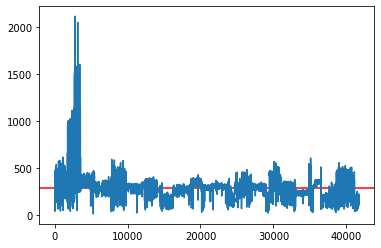

In [ ]:
X_len=[len(x) for x in X]
plt.axhline(y=sum(X_len)/len(X_len), xmin=0, xmax=1, color='red')
plt.plot(range(0,len(X_len)),X_len)

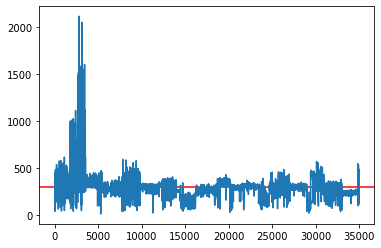

In [ ]:
plt.axhline(y=sum(X_len[:35000])/len(X_len[:35000]), xmin=0, xmax=1,color='red')
plt.plot(range(0,len(X_len[:35000])),X_len[:35000])

In [ ]:
classes=['N','L','R','A','V','/']
n_classes=len(classes)
count_classes=[0]*n_classes

X,Y=[],[]
maximum_counting=10000

for i in range(len(records)):
    if records[i].split('/')[-1].split('.')[0]=='232':
        continue
    record=pd.read_csv(records[i],index_col=0)
    signals=[]
    try:
        signals.extend(record.loc[:,"'MLII'"].to_list())
    except:
        #메인 리드가 MLII가 아닌 것은 제외한다.
        print(records[i].split('/')[-1]+" 메인 리드 :",end=" ")
        print(record.columns[0])
        continue

    beat=[]
    a=[]
    annotation=open(annotations[i],'r')
    lines=annotation.readlines()
    for j in range(3,len(lines)): # 1번 ~ 2번: 시작 지점이라 이상함
        now_tmp=list(filter(None,lines[j].split(" ")))
        # AUX 부분에 이상한 것 있으면 제외
        if now_tmp[-1] != '0\n':
            continue
        before_tmp=list(filter(None,lines[j-1].split(" ")))
        now_num_sample=int(now_tmp[1])
        before_num_sample=int(before_tmp[1])
        beat_type=now_tmp[2]
        if (beat_type in classes):
            beat_idx=classes.index(beat_type)
            '''
            #################확인 필요#####################
            if count_classes[beat_idx] > maximum_counting: 
                continue
            
            else:
                count_classes[beat_idx]+=1
                beat=signals[before_num_sample:now_num_sample]
                X.append(beat)
                Y.append(beat_idx)
                if len(signals[before_num_sample:now_num_sample])>=1000:
                    print("심박 1000 이상 찍힘 : ",records[i].split('/')[-1].split('.')[0],"-",len(signals[before_num_sample:now_num_sample]))
                if len(signals[before_num_sample:now_num_sample])<=20:
                    print("심박 20 이하 찍힘 : ",records[i].split('/')[-1].split('.')[0],"-",len(signals[before_num_sample:now_num_sample]),beat_type)
            '''
            count_classes[beat_idx]+=1
            beat=signals[before_num_sample:now_num_sample]
            X.append(beat)
            Y.append(beat_idx)

102.csv 메인 리드 : 'V5'
104.csv 메인 리드 : 'V5'


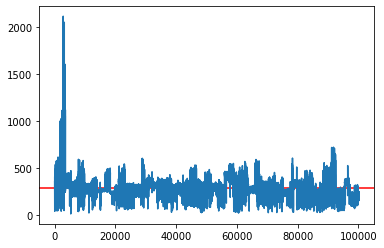

In [ ]:
X_len=[len(x) for x in X]
plt.axhline(y=sum(X_len)/len(X_len), xmin=0, xmax=1, color='red')
plt.plot(range(0,len(X_len)),X_len)

## 3-2. Data shape

#### 비트 길이의 분포를 확인한다.
정규분포를 따른다.

1sigma 범위 : 69%

2sigma 범위 : 94%

데이터의 개수 100198
평균 281.8624124234017
분산 6228.921866880269
표준 편차 78.92351909843015
최대값 2114
최소값 11
중앙값 273.0
1사분위 235.0
2사분위 273.0
3사분위 321.0


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


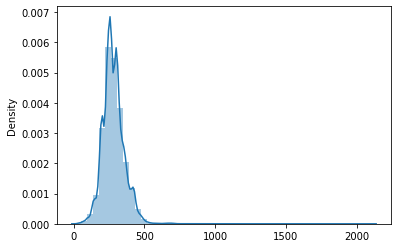

In [ ]:
import seaborn as sns
len_x=[len(x) for x in X]

print("데이터의 개수",len(len_x)) # 데이터의 개수
print("평균",np.mean(len_x)) # 평균
print("분산",np.var(len_x)) # 분산
print("표준 편차",np.std(len_x)) # 표준 편차
print("최대값",np.max(len_x)) # 최대값
print("최소값",np.min(len_x)) # 최소값
print("중앙값",np.median(len_x)) # 중앙값
print("1사분위",np.percentile(len_x, 25)) # 1사분위 수
print("2사분위",np.percentile(len_x, 50)) # 2사분위 수 = 중앙값
print("3사분위",np.percentile(len_x, 75)) # 3사분위 수

sns.distplot(len_x)

In [ ]:
upper=np.mean(len_x)+np.std(len_x)
lower=np.mean(len_x)-np.std(len_x)
cnt=0
for item in len_x:
    if upper>=item and lower<=item:
        cnt+=1
display(cnt/len(len_x))
upper=np.mean(len_x)+2*np.std(len_x)
lower=np.mean(len_x)-2*np.std(len_x)
cnt=0
for item in len_x:
    if upper>=item and lower<=item:
        cnt+=1
display(cnt/len(len_x))

0.731282061518194

0.9621549332322002

(100198,) (100198,)
N
V
A
R
/
L
(100198,)


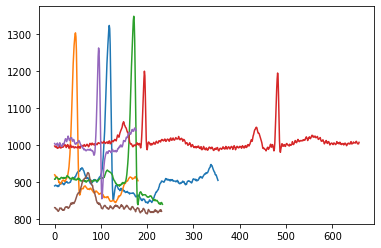

In [ ]:
print(np.shape(X),np.shape(Y))

tmp=[]
for i in range(len(X)):
    if Y[i] not in tmp:
        tmp.append(Y[i])
        plt.plot(X[i])
        print(classes[Y[i]])
print(np.shape(X))

In [ ]:
max_len=np.max(len_x)
for x in X:
    if len(x) < max_len:
        right_padding_size=int((max_len-len(x))/2)
        left_padding_size=(max_len-len(x))-right_padding_size
        x[:]=([0]*right_padding_size)+x[:]+([0]*left_padding_size)

In [ ]:
print(np.shape(X),np.shape(Y))

(100198, 2114) (100198,)


In [ ]:
# X 배열 끝에 Y값 삽입
for i in range(len(X)):
    X[i].append(Y[i])

In [ ]:
X_train_df = pd.DataFrame(X)
#각각의 beat type의 count
per_class=X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class) #V5 포함했을 때와 비교했을 때 '5'의 카운트가 크게 차이남

0    68850
1     8072
2     7253
5     7024
4     6668
3     2331
Name: 2114, dtype: int64


In [ ]:
X_train_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2113,2114
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100193,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100194,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100195,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100196,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 1-4. Resampling

(확인 필요)

### 5000 이상 : 중복 X   // 5000 이하 : 중복 O

In [ ]:
from sklearn.utils import resample
resampled_X_train_df=pd.DataFrame()
for name, group in X_train_df.groupby(X_train_df[X_train_df.shape[1]-1]):
    if len(group)>5000:
        tmp=resample(group,replace=False,n_samples=5000, random_state=880818)
    else:
        tmp=resample(group,replace=True, n_samples=5000, random_state=880818)
    print(len(tmp))
    resampled_X_train_df=pd.concat([resampled_X_train_df,tmp])
print(len(resampled_X_train_df))
resampled_X_train_df

5000
5000
5000
5000
5000
5000
30000


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,2090,2091,2092,2093,2094,2095,2096,2097,2098,2099,2100,2101,2102,2103,2104,2105,2106,2107,2108,2109,2110,2111,2112,2113,2114
96717,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
95259,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
82464,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
82702,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3582,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68198,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
38616,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
39240,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
52146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5


# 2. Modeling

## 2-1. Set 분할

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

In [ ]:
train, test=train_test_split(resampled_X_train_df,test_size=0.30)
print("X_train : ",len(train))
print("X_test : ",len(test))

X_train :  21000
X_test :  9000


In [ ]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
print("Y shape :",np.shape(y_train),np.shape(y_test))

x_train=train.iloc[:,:train.shape[1]-1].values
x_test=test.iloc[:,:test.shape[1]-1].values
x_train=x_train.reshape(len(x_train),x_train.shape[1],1)
x_test=x_test.reshape(len(x_test),x_test.shape[1],1)
print("X shape :",np.shape(x_train),np.shape(x_test))

Y shape : (21000, 6) (9000, 6)
X shape : (21000, 2114, 1) (9000, 2114, 1)


## 2-2. modeling 첫 시도

In [ ]:
from keras.layers import Input, Convolution1D, MaxPool1D, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix

In [ ]:
def network(x_train,y_train,x_test,y_test):
    im_shape=(x_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape),name='inputs_cnn')
    #conv. layer 1
    conv1_1=Convolution1D(64,(6),activation="elu",input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    #pooling layer 1
    pool1=MaxPool1D(pool_size=(3),strides=(2),padding="same")(conv1_1)
    #conv. layer 2
    conv2_1=Convolution1D(128,(3),activation="elu",input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    #conv. layer 3
    conv3_1=Convolution1D(128,(3),activation="elu",input_shape=im_shape)(conv2_1)
    conv3_1=BatchNormalization()(conv3_1)
    #pooling layer 2
    pool2=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv3_1)
    #conv. layer 4
    conv4_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(pool2)
    conv4_1=BatchNormalization()(conv4_1)
    #conv. layer 5
    conv5_1=Convolution1D(256,(3),activation="elu",input_shape=im_shape)(conv4_1)
    conv5_1=BatchNormalization()(conv5_1)
    #pooling layer 3
    pool3=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv5_1)
    #flattened layer 1
    flatten=Flatten()(pool3)
    #dense layers
    dense_end1=Dense(1024,activation='elu')(flatten)
    
    #output layers
    main_output=Dense(6,activation='softmax',name='main_output')(dense_end1)
    
    model=Model(inputs=inputs_cnn,outputs=main_output)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    callbacks=[EarlyStopping(monitor='val_loss',patience=8),
              ModelCheckpoint(filepath='best_model2.h5',monitor='val_loss',save_best_only=True)]
    
    history=model.fit(x_train, y_train, epochs=2, callbacks=callbacks, batch_size=32,validation_data=(x_test,y_test))
    model.load_weights('best_model2.h5')
    return (model, history)

In [ ]:
model, history=network(x_train,y_train,x_test,y_test)

Epoch 1/2
657/657 [==============================] - 916s 1s/step - loss: 1.1049 - accuracy: 0.7329 - val_loss: 0.4939 - val_accuracy: 0.8121
Epoch 2/2
657/657 [==============================] - 829s 1s/step - loss: 0.4106 - accuracy: 0.8678 - val_loss: 0.5412 - val_accuracy: 0.8128


In [ ]:
scores=model.evaluate((x_test),y_test,verbose=0)
print("Accuracy:",scores[1]*100)

Accuracy: 81.21111392974854


In [ ]:
from keras import activations,optimizers
from keras.layers import Dropout,GlobalMaxPool1D
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

## 마지막 모델

In [ ]:
def network(x_train,y_train,x_test,y_test):
    im_shape=(x_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape),name='inputs_cnn')
    #conv. layer 1
    conv1_1=Convolution1D(16,kernel_size=5,activation=activations.relu,padding="valid")(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    conv1_2=Convolution1D(16,kernel_size=5,activation=activations.relu,padding="valid")(conv1_1)
    conv1_2=BatchNormalization()(conv1_2)
    #pooling layer 1
    pool1=MaxPool1D(pool_size=2)(conv1_2)
    pool1=Dropout(rate=0.1)(pool1)
    #conv. layer 2
    conv2_1=Convolution1D(32,kernel_size=3,activation=activations.relu,padding="valid")(pool1)
    conv2_1=BatchNormalization()(conv1_2)
    conv2_2=Convolution1D(32,kernel_size=3,activation=activations.relu,padding="valid")(conv2_1)
    conv2_2=BatchNormalization()(conv2_2)
    #pooling layer 2
    pool2=MaxPool1D(pool_size=2)(conv2_2)
    pool2=Dropout(rate=0.1)(pool2)
    #conv. layer 3
    conv3_1=Convolution1D(32,kernel_size=3,activation=activations.relu,padding="valid")(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    conv3_2=Convolution1D(32,kernel_size=3,activation=activations.relu,padding="valid")(conv3_1)
    conv3_2=BatchNormalization()(conv3_2)
    #pooling layer 3
    pool3=MaxPool1D(pool_size=2)(conv3_2)
    pool3=Dropout(rate=0.1)(pool3)
    #conv. layer 4
    conv4_1=Convolution1D(256,kernel_size=3,activation=activations.relu,padding="valid")(pool3)
    conv4_1=BatchNormalization()(conv4_1)
    conv4_2=Convolution1D(256,kernel_size=3,activation=activations.relu,padding="valid")(conv4_1)
    conv4_2=BatchNormalization()(conv4_2)
    #pooling layer 4
    pool4=GlobalMaxPool1D()(conv4_2)
    pool4=Dropout(rate=0.2)(pool4)
    
    dense_1=Dense(64,activation=activations.relu,name="dense_1")(pool4)
    dense_2=Dense(64,activation=activations.relu,name="dense_2")(dense_1)
    #output layers
    main_output=Dense(6,activation='softmax',name='main_output')(dense_2)
    
    model=Model(inputs=inputs_cnn,outputs=main_output)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    callbacks=[EarlyStopping(monitor='val_loss',patience=8),
              ModelCheckpoint(filepath='best_model3.h5',monitor='val_loss',save_best_only=True)]
    
    history=model.fit(x_train, y_train, epochs=5, callbacks=callbacks, batch_size=32,validation_data=(x_test,y_test))
    model.load_weights('best_model3.h5')
    return (model, history)

model, history=network(x_train,y_train,x_test,y_test)
scores=model.evaluate((x_test),y_test,verbose=0)
print("Accuracy:",scores[1]*100)

Epoch 1/5
657/657 [==============================] - 571s 869ms/step - loss: 1.9135 - accuracy: 0.2432 - val_loss: 1.6472 - val_accuracy: 0.3386
Epoch 2/5
 41/657 [>.............................] - ETA: 7:53 - loss: 1.6058 - accuracy: 0.3476

KeyboardInterrupt: ignored

In [ ]:
def network(x_train,y_train,x_test,y_test):
    im_shape=(x_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape),name='inputs_cnn')
    #conv. layer 1
    conv1_1=Convolution1D(64,(6),activation="relu",input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    #pooling layer 1
    pool1=MaxPool1D(pool_size=(3),strides=(2),padding="same")(conv1_1)
    #conv. layer 2
    conv2_1=Convolution1D(128,(3),activation="relu",input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    #conv. layer 3
    conv3_1=Convolution1D(128,(3),activation="relu",input_shape=im_shape)(conv2_1)
    conv3_1=BatchNormalization()(conv3_1)
    #pooling layer 2
    pool2=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv3_1)
    #conv. layer 4
    conv4_1=Convolution1D(256,(3),activation="relu",input_shape=im_shape)(pool2)
    conv4_1=BatchNormalization()(conv4_1)
    #conv. layer 5
    conv5_1=Convolution1D(256,(3),activation="relu",input_shape=im_shape)(conv4_1)
    conv5_1=BatchNormalization()(conv5_1)
    #pooling layer 3
    pool3=MaxPool1D(pool_size=(2),strides=(2),padding="same")(conv5_1)
    #flattened layer 1
    flatten=Flatten()(pool3)
    #dense layers
    dense_end1=Dense(1024,activation='relu')(flatten)
    dense_end2=Dense(1024,activation='relu')(dense_end1)
    #output layers
    main_output=Dense(6,activation='softmax',name='main_output')(dense_end2)
    
    model=Model(inputs=inputs_cnn,outputs=main_output)
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    
    callbacks=[EarlyStopping(monitor='val_loss',patience=8),
              ModelCheckpoint(filepath='best_model3.h5',monitor='val_loss',save_best_only=True)]
    
    history=model.fit(x_train, y_train, epochs=5, callbacks=callbacks, batch_size=32,validation_data=(x_test,y_test))
    model.load_weights('best_model2.h5')
    return (model, history)

model, history=network(x_train,y_train,x_test,y_test)

Epoch 1/5
657/657 [==============================] - 1300s 2s/step - loss: 1.7355 - accuracy: 0.4753 - val_loss: 312.4022 - val_accuracy: 0.1621
Epoch 2/5
131/657 [====>.........................] - ETA: 15:55 - loss: 1.1885 - accuracy: 0.5398

In [ ]:
f1 = f1_score(y_test, pred_test, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test, pred_test)

print("Test accuracy score : %s "% acc)

ValueError: ignored

In [ ]:
y_pred=model.predict(x_test)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(cnf_matrix)

[[   0    1    2  478 1049    0]
 [   0    0    0  434 1131    0]
 [   0    0    1  535  923    0]
 [   0    0    0  416 1076    0]
 [   0    0    0  369 1135    0]
 [   0    0    0  418 1032    0]]


In [ ]:
import itertools

def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

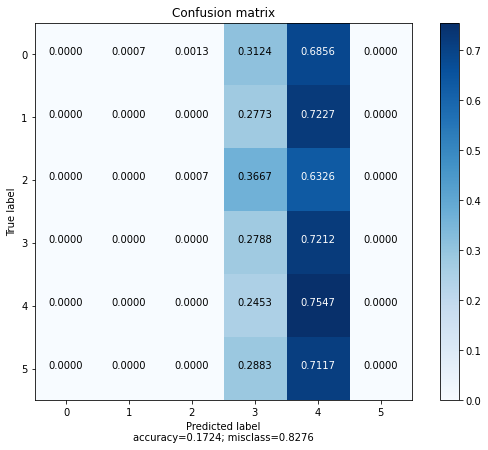

In [ ]:
plot_confusion_matrix(cnf_matrix, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix')